# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/MobileNetV2_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3    4         5         6  \
41001 201546 -0.324996 -0.982826 -0.245813 -0.625881 -1.0 -0.468733 -0.975876   
      201547 -0.324996 -0.982826 -0.245813 -0.625881 -1.0 -0.468733 -0.975876   
      201548 -0.324996 -0.982826 -0.245813 -0.625881 -1.0 -0.468733 -0.975876   
      201549 -0.324996 -0.982826 -0.245813 -0.625881 -1.0 -0.468733 -0.975876   
      201550 -0.324996 -0.982826 -0.245813 -0.625881 -1.0 -0.468733 -0.975876   

                     7         8    9  ...      1271      1272  1273  \
41001 201546 -0.966061  0.549074 -1.0  ... -0.992796 -0.947927  -1.0   
      201547 -0.966061  0.549074 -1.0  ... -0.992796 -0.947927  -1.0   
      201548 -0.966061  0.549074 -1.0  ... -0.992796 -0.947927  -1.0   
      201549 -0.966061  0.549074 -1.0  ... -0.992796 -0.947927  -1.0   
      201550 -0.966061  0.549074 -1.0  ... -0.992796 -0.947927  -1.0   

                  1274  1275  1276  1277      1278      1279    Labels  
41001 201546 -0.996755  -1.0  -1.0  -1.0  0.495648 -0.872687 -0.861740  
      201547 -0.996755  -1.0  -1.0  -1.0  0.495648 -0.872687 -0.854589  
      201548 -0.996755  -1.0  -1.0  -1.0  0.495648 -0.872687 -0.856973  
      201549 -0.996755  -1.0  -1.0  -1.0  0.495648 -0.872687 -0.856973  
      201550 -0.996755  -1.0  -1.0  -1.0  0.495648 -0.872687 -0.823600  

[5 rows x 1281 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546 -0.324996 -0.982826 -0.245813 -0.625881 -1.000000 -0.468733   
     201547 -0.585884 -1.000000 -0.994944 -0.432415 -0.985274 -0.316126   
     201548 -0.324996 -0.982826 -0.245813 -0.625881 -1.000000 -0.468733   
     201549 -0.305571 -0.878950 -0.882332 -0.388076 -0.769113 -0.337240   
     201550 -0.324996 -0.982826 -0.245813 -0.625881 -1.000000 -0.468733   

                    6         7         8        9  ...      1271      1272  \
5360 201546 -0.975876 -0.966061  0.549074 -1.00000  ... -0.992796 -0.947927   
     201547 -1.000000 -0.769799  0.827416 -0.99471  ... -0.948615 -0.657048   
     201548 -0.975876 -0.966061  0.549074 -1.00000  ... -0.992796 -0.947927   
     201549 -0.857882 -0.252514 -0.795252 -1.00000  ... -0.135855 -1.000000   
     201550 -0.975876 -0.966061  0.549074 -1.00000  ... -0.992796 -0.947927   

                 1273      1274      1275  1276  1277      1278      1279  \
5360 201546 -1.000000 -0.996755 -1.000000  -1.0  -1.0  0.495648 -0.872687   
     201547 -1.000000 -1.000000 -0.914761  -1.0  -1.0  0.596301 -0.863241   
     201548 -1.000000 -0.996755 -1.000000  -1.0  -1.0  0.495648 -0.872687   
     201549 -0.998701 -0.876721 -0.147139  -1.0  -1.0 -1.000000 -0.580934   
     201550 -1.000000 -0.996755 -1.000000  -1.0  -1.0  0.495648 -0.872687   

               Labels  
5360 201546 -0.990465  
     201547 -0.969011  
     201548 -0.995232  
     201549 -0.997616  
     201550 -0.971395  

[5 rows x 1281 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 1281)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 1280)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 1280)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

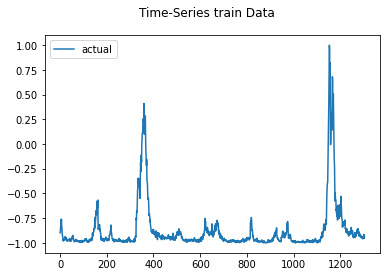

2023-03-04 23:42:14.817488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 23:42:14.817539: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 23:42:14.817569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 23:42:14.817842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:42:15.122560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 44.034
Test sMAPE: 136.740
Test RMSE: 57.235
{'mae': 44.03392784626572, 'smape': 136.73970690536618, 'rmse': 57.234518966464925}


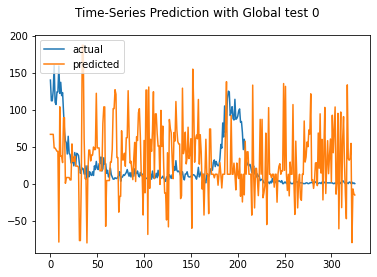

Test MAE: 60.648
Test sMAPE: 148.722
Test RMSE: 74.080
{'mae': 60.647819108209724, 'smape': 148.72218911142332, 'rmse': 74.08047158410362}


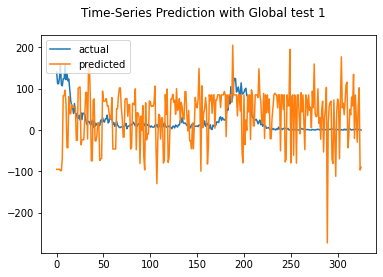

Test MAE: 44.445
Test sMAPE: 126.316
Test RMSE: 52.959
{'mae': 44.444564448909524, 'smape': 126.315748049367, 'rmse': 52.959392157989214}


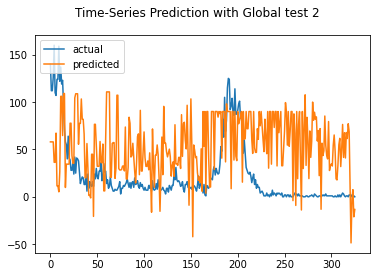

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.840
Test sMAPE: 134.930
Test RMSE: 56.628
{'mae': 47.839954645812874, 'smape': 134.92953438972282, 'rmse': 56.62782402423297}


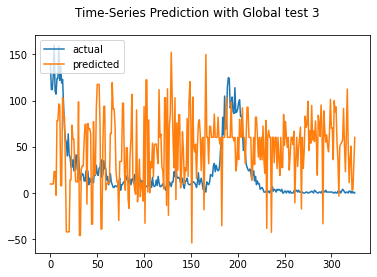

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 44.279
Test sMAPE: 135.710
Test RMSE: 56.281
{'mae': 44.27948408057353, 'smape': 135.70976869413235, 'rmse': 56.28060333070429}


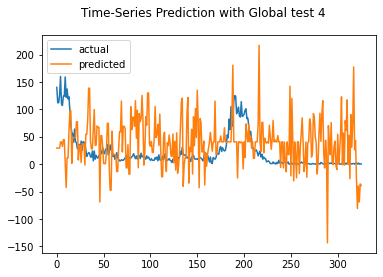

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 50.242
Test sMAPE: 137.376
Test RMSE: 60.195
{'mae': 50.24172383181156, 'smape': 137.37561127306114, 'rmse': 60.19531139895288}


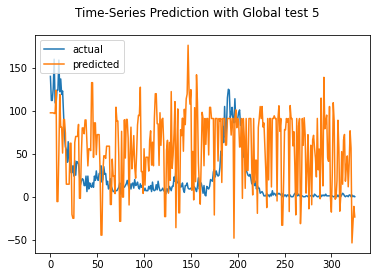

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 44.112
Test sMAPE: 134.061
Test RMSE: 54.059
{'mae': 44.11243289014313, 'smape': 134.06118755326105, 'rmse': 54.05946659484343}


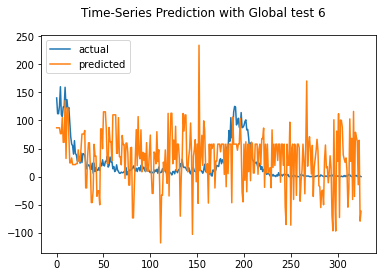

Test MAE: 94.754
Test sMAPE: 160.211
Test RMSE: 123.209
{'mae': 94.75375041420475, 'smape': 160.21147042917158, 'rmse': 123.20933698756768}


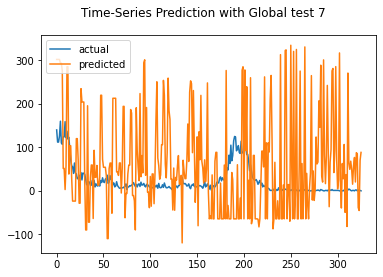

Test MAE: 75.158
Test sMAPE: 149.167
Test RMSE: 97.073
{'mae': 75.15803426650405, 'smape': 149.16725786577854, 'rmse': 97.07348930979143}


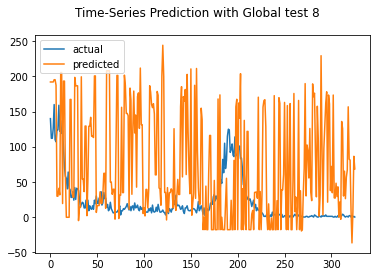

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 53.972
Test sMAPE: 140.420
Test RMSE: 66.395
{'mae': 53.97166920320754, 'smape': 140.42049379424367, 'rmse': 66.39472845285643}


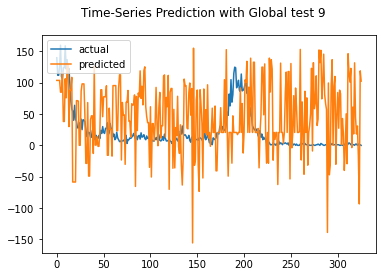

rmse : average=69.812, std=21.827
mae : average=55.948, std=15.968
smape : average=140.365, std=9.228


([69.81151428075069, 21.826840379269655],
 [55.948336073564235, 15.967833003191464],
 [140.36529680655275, 9.228336860921386])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=10, plot_samples=True, Municipality='Global')
